In [1]:
!pip install bitsandbytes #reduce memory usage by compressing the model (e.g., using 4-bit or 8-bit quantization)
!pip install accelerate #optimizes model loading and running across devices

from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig # Imports a configuration tool to set up memory-efficient model loading (e.g., quantization settings)



In [2]:
#Sets up 4-bit quantization to reduce memory usage while loading the model.
bnb_config = BitsAndBytesConfig(load_in_4bit=True)
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B" #pre-trained model
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, max_seq_length=2048) #converts text to tokens
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, trust_remote_code=True, device_map="auto")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
!pip install pandas faiss-cpu sentence-transformers


In [4]:
!pip install datasets

# Load Data

In [5]:
# !pip install fsspec==2023.6.0 --force-reinstall


In [6]:
from datasets import load_dataset
# Clear dataset cache and reload
!rm -rf ~/.cache/huggingface/datasets/ruslanmv___ai-medical-chatbot*
# Load the dataset
dataset = load_dataset("ruslanmv/ai-medical-chatbot")

# Access the training split
train_data = dataset['train']

# Display a sample dialogue
print(train_data[0])

train_data


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/256916 [00:00<?, ? examples/s]

{'Description': 'Q. What does abutment of the nerve root mean?', 'Patient': 'Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for\xa0annular bulging and tear?', 'Doctor': 'Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online -->'}


Dataset({
    features: ['Description', 'Patient', 'Doctor'],
    num_rows: 256916
})

In [7]:
import pandas as pd

# Assuming `train_data` is a Hugging Face Dataset
df = train_data.to_pandas()

df

,Description,Patient,Doctor
0,Q. What does abutment of the nerve root mean?,"Hi doctor,I am just wondering what is abutting...",Hi. I have gone through your query with dilige...
1,Q. What should I do to reduce my weight gained...,"Hi doctor, I am a 22-year-old female who was d...",Hi. You have really done well with the hypothy...
2,Q. I have started to get lots of acne on my fa...,Hi doctor! I used to have clear skin but since...,Hi there Acne has multifactorial etiology. Onl...
3,Q. Why do I have uncomfortable feeling between...,"Hello doctor,I am having an uncomfortable feel...",Hello. The popping and discomfort what you fel...
4,Q. My symptoms after intercourse threatns me e...,"Hello doctor,Before two years had sex with a c...",Hello. The HIV test uses a finger prick blood ...
...,...,...,...
256911,Why is hair fall increasing while using Bontre...,I am suffering from excessive hairfall. My doc...,"Hello Dear Thanks for writing to us, we are he..."
256912,Why was I asked to discontinue Androanagen whi...,"Hi Doctor, I have been having severe hair fall...","hello, hair4u is combination of minoxid..."
256913,Can Mintop 5% Lotion be used by women for seve...,Hi..i hav sever hair loss problem so consulted...,HI I have evaluated your query thoroughly you...
256914,Is Minoxin 5% lotion advisable instead of Foli...,"Hi, i am 25 year old girl, i am having massive...",Hello and Welcome to ‘Ask A Doctor’ service.I ...


# preprocessing

In [8]:
# Check for null or empty values
print(df.isnull().sum())

Description    0
Patient        0
Doctor         0
dtype: int64


In [9]:
print(df.duplicated().sum())

10378


In [10]:
print(df.describe(include='all'))

                                              Description  \
count                                              256916   
unique                                             228722   
top     Q. Why do periods get delayed after first time...   
freq                                                 1137   

                                                  Patient  \
count                                              256916   
unique                                             246006   
top     Hello doctor, My fiancee and I had unprotected...   
freq                                                 1137   

                                                   Doctor  
count                                              256916  
unique                                             242150  
top     Hi. For further doubts consult a sexologist on...  
freq                                                 1519  


### remove duplicate

In [11]:
df = df.drop_duplicates()
print(f"Remaining rows: {len(df)}")

Remaining rows: 246538


### Remove repeated question

In [12]:
df = df.drop_duplicates(subset='Description')
print(f"Remaining rows: {len(df)}")


Remaining rows: 228722


In [13]:
df.describe(include='all')


,Description,Patient,Doctor
count,228722,228722,228722
unique,228722,228271,224740
top,Are Biotin supplements need to reduce severe h...,"Hello docs n experts, Since yesterday I m ejac...",Hi. For further information consult an interna...
freq,1,9,144


# Visualization

#### Length of Text per Column

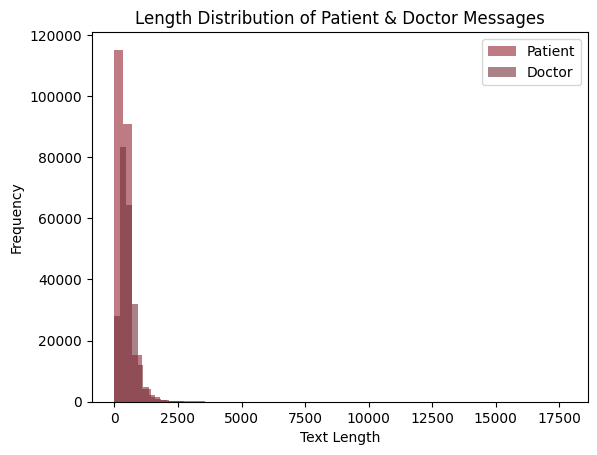

In [14]:
import matplotlib.pyplot as plt

df['patient_len'] = df['Patient'].apply(len)
df['doctor_len'] = df['Doctor'].apply(len)

plt.hist(df['patient_len'], bins=50, alpha=0.7, label='Patient',color='#A3434f')
plt.hist(df['doctor_len'], bins=50, alpha=0.6, label='Doctor',color='#722f37')
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Length Distribution of Patient & Doctor Messages")
plt.legend()
plt.show()


#### Most Frequent Medical Topics

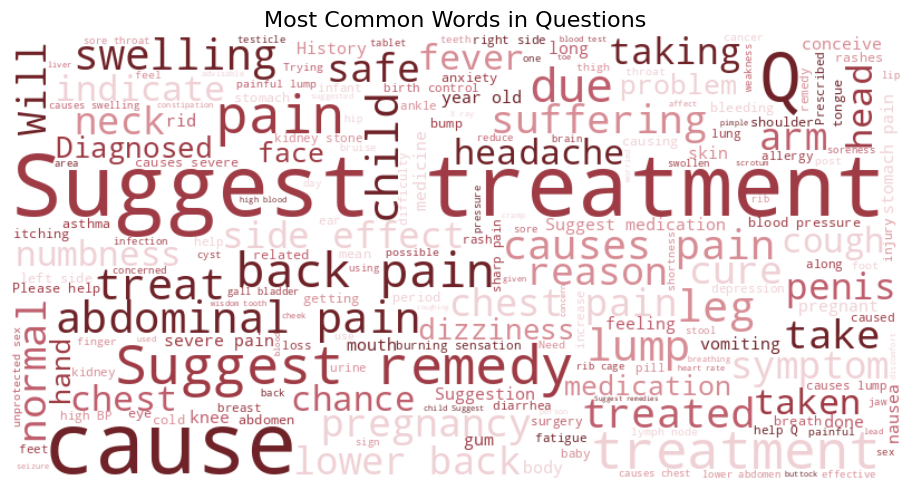

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

# Define your custom color palette from the pie chart
colors = ['#6f2328', '#9e3b45', '#bf5f6d', '#d78d95', '#efd1d5']

# Custom color function to randomly pick from palette
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

# Generate word cloud text
text = " ".join(df['Description'].tolist())
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      color_func=custom_color_func).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Questions", fontsize=16)
plt.tight_layout()
plt.show()


## NLP preprocessing

In [16]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
from datasets import load_dataset
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
# Step 2: Text Cleaning Function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove greetings and conversational markers (e.g., "hi.", "hello doctor")
    text = re.sub(r'^(hi\.|hello doctor|hi doctor|dear doctor|hello\.|hi,)\s*', '', text, flags=re.IGNORECASE)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Optional: Remove stop words
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    return text

In [18]:

# Download the required NLTK resource
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [19]:
# Apply cleaning to relevant columns
df['Description'] = df['Description'].apply(clean_text)
df['Patient'] = df['Patient'].apply(clean_text)
df['Doctor'] = df['Doctor'].apply(clean_text)

In [20]:
# Step 3: Verify cleaning
print("Sample after cleaning:\n", df[['Description', 'Patient', 'Doctor']].head(2))

Sample after cleaning:
                                          Description  \
0                         q abutment nerve root mean   
1  q reduce weight gained due genetic hypothyroidism   

                                             Patient  \
0  wondering abutting abutment nerve root means b...   
1  22yearold female diagnosed hypothyroidism gene...   

                                              Doctor  
0  gone query diligence would like know help info...  
1  really done well hypothyroidism problem levels...  


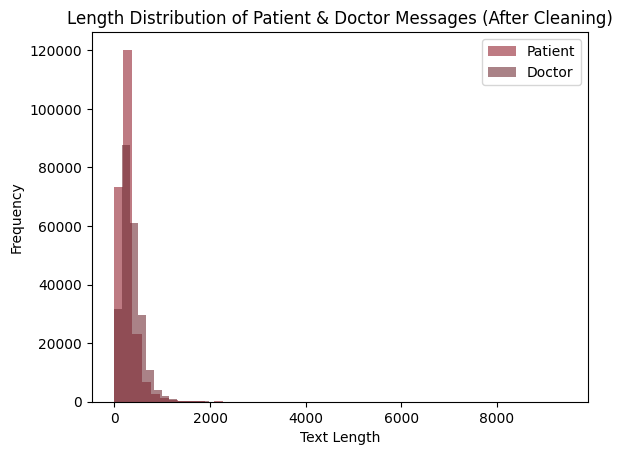

In [21]:
# Step 4: Visualization after cleaning
# Text length distribution
df['patient_len'] = df['Patient'].apply(len)
df['doctor_len'] = df['Doctor'].apply(len)

plt.hist(df['patient_len'], bins=50, alpha=0.7, label='Patient',color='#A3434f')
plt.hist(df['doctor_len'], bins=50, alpha=0.6, label='Doctor',color='#722f37')
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Length Distribution of Patient & Doctor Messages (After Cleaning)")
plt.legend()
plt.show()

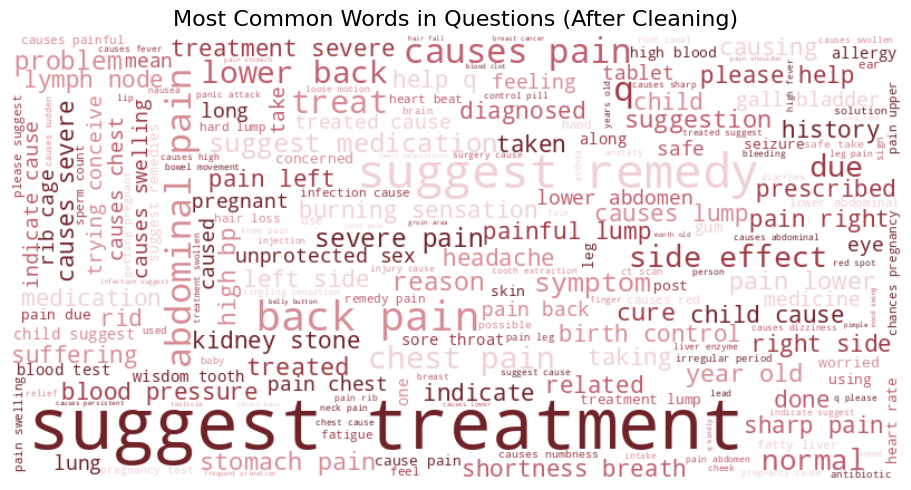

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

# Pie chart-inspired color palette (darkest to lightest)
colors = ['#6f2328', '#9e3b45', '#bf5f6d', '#d78d95', '#efd1d5']

# Custom color function that randomly selects a color from the palette
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

# Generate word cloud text
text = " ".join(df['Description'].tolist())
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      color_func=custom_color_func).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Questions (After Cleaning)", fontsize=16)
plt.tight_layout()
plt.show()


In [23]:
# Step 5: Save cleaned dataset
df.to_csv("cleaned_medical_data.csv", index=False)
print("Cleaned dataset saved as 'cleaned_medical_data.csv'")

Cleaned dataset saved as 'cleaned_medical_data.csv'


In [24]:
df_cleaned = pd.read_csv("cleaned_medical_data.csv")
df_cleaned.head()

,Description,Patient,Doctor,patient_len,doctor_len
0,q abutment nerve root mean,wondering abutting abutment nerve root means b...,gone query diligence would like know help info...,110,80
1,q reduce weight gained due genetic hypothyroidism,22yearold female diagnosed hypothyroidism gene...,really done well hypothyroidism problem levels...,352,1064
2,q started get lots acne face particularly fore...,used clear skin since moved new place started ...,hi acne multifactorial etiology acne soap impr...,384,352
3,q uncomfortable feeling middle spine left shou...,uncomfortable feeling middle spine left should...,popping discomfort felt either improper scapul...,459,422
4,q symptoms intercourse threatns even negative ...,two years sex call girl dark location 10 to15 ...,hiv test uses finger prick blood sample result...,701,501


In [25]:
# df_cleaned['combined_text'] = df_cleaned['combined_text'].fillna("")


In [26]:
from sentence_transformers import SentenceTransformer  # Convert text to embeddings

# Combine Description and Patient into one column
df_cleaned['combined_text'] = df_cleaned['Description'] + " " + df_cleaned['Patient']

# Fill any missing combined_text values
df_cleaned['combined_text'] = df_cleaned['combined_text'].fillna("")

# Load the embedding model
model_zeft = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Generate sentence embeddings
embeddings = model_zeft.encode(df_cleaned['combined_text'].tolist(), show_progress_bar=True)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7148 [00:00<?, ?it/s]

In [27]:
!pip install faiss

ERROR: Could not find a version that satisfies the requirement faiss (from versions: none)
ERROR: No matching distribution found for faiss


In [28]:
import pandas as pd
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
# Create a FAISS index (L2 = Euclidean distance)
dimension = embeddings.shape[1]  # Get embedding dimension (e.g., 384)
index = faiss.IndexFlatL2(dimension)  # Flat index with L2 distance

# Add the embeddings to the index
index.add(np.array(embeddings))

# Save the FAISS index for later use
faiss.write_index(index, "medical_chatbot_index.faiss")

# Save the metadata (e.g., reference info like patient question)
df_cleaned['Index'] = range(len(df_cleaned))  # Assign index to link embeddings
metadata = df_cleaned[['Index', 'Description']]  # Choose a column for reference (TOC replaced with 'Description')
metadata.to_csv("metadata.csv", index=False, encoding="utf-8-sig")

# ------------------ What this does ------------------
# This creates a fast searchable index for similarity-based retrieval.
# You can later use this to find the most relevant patient question or chatbot reply using new queries.


In [29]:
def query_chatbot_with_fallback(query, k=5):
    """
    Search the medical chatbot dataset using metadata (Description) first.
    If no match is found, fall back to semantic search with FAISS.
    """
    # Step 1: Try filtering by metadata (e.g., 'Description' column)
    filtered_df = df_cleaned[df_cleaned['Description'].str.contains(query, case=False, na=False)]

    if not filtered_df.empty:
        print("📋 Results from metadata filtering (text match in 'Description'):")
        return filtered_df[['Description', 'Patient', 'Doctor']].head(k)

    # Step 2: Fallback to vector similarity search using FAISS
    print("🔍 No metadata match. Falling back to semantic search...")

    # Load the FAISS index
    index = faiss.read_index("medical_chatbot_index.faiss")

    # Encode the query to get its embedding
    query_embedding = model_zeft.encode([query])

    # Perform FAISS vector search
    distances, indices = index.search(np.array(query_embedding), k)

    # Retrieve corresponding rows
    results = df_cleaned.iloc[indices[0]]
    return results[['Description', 'Patient', 'Doctor']]

# Run an example query about anemia
query = "anemia"
results = query_chatbot_with_fallback(query, k=5)

# Display results in readable format
for idx, row in results.iterrows():
    print(f"📌 Description: {row['Description']}")
    print(f"🧑 Patient says: {row['Patient']}")
    print(f"👨‍⚕️ Doctor responds: {row['Doctor']}")
    print("-" * 60)
# Built a hybrid retriever (metadata + vector)



📋 Results from metadata filtering (text match in 'Description'):
📌 Description: q causes pain dehydration sickle cell anemia patient
🧑 Patient says: sickle cell anemia problem age 30 years dehydration time getting pain issue dangerous
👨‍⚕️ Doctor responds: yes sickle cell anemia disease rbc shape changes dehydration oxygen level goes body usually red blood cell round plate shape dehydration less oxygen time shape red blood cell becomes sickle shape rbc stick together block blood vessels produce ischemia reduce obstruction need fluids obstruction lung spleen kidney organ dangerous severe painful avoid dehydration conditions severe exercise avoid going hill stations oxygen less drink adequate water
------------------------------------------------------------
📌 Description: q shortness breath iron deficiency anemia
🧑 Patient says: age 26 iron deficiency anemia hb level 11 ferritin 18 sometimes felt shortness breath taking iron medicine quit taking iron tablets situation gets worse time
👨‍

In [30]:
!pip install fschat


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.7/137.7 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.0/739.0 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 5.9 MB/s eta 0:00:00
  Created wheel for wavedrom: filename=wavedrom-2.0.3.post3-py2.py3-none-any.whl size=30084 sha256=091aff85331f415aa93d05399c4f574ea9ee4529480a420d6b9532c827b2acdf
  Stored in directory: /root/.cache/pip/wheels/23/cf/3b/4dcf6b22fa41c5ece715fa5f4e05

In [31]:
import re

def extract_qa(text):
    """
    Extract only the final answer from the model output.
    Removes long prompt, history, and keeps only the answer content.
    """
    # Try to extract content after the last 'Answer:' occurrence
    parts = re.split(r"\bAnswer:\s*", text)
    if len(parts) >= 2:
        answer = parts[-1].strip()

        # Optional: cut off at first empty line or double newline if it keeps going
        answer = re.split(r'\n\s*\n', answer)[0].strip()

        return answer

    return text.strip()


In [32]:
!pip install fpdf
!pip install tqdm

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=a9e2a3e5b80ea20d1ea28a484f213b2feb9a48263d72d929a26d1acaaab3f598
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [33]:
from fpdf import FPDF
from tqdm import tqdm


In [34]:
test_queries = [
    # Basic Questions
    "What is anemia?",
    "What are the common symptoms of anemia?",
    "What causes anemia?",
    "How is anemia diagnosed?",
    "What blood tests are used to detect anemia?",
    "What is hemoglobin and why is it important?",
    "What are the normal hemoglobin levels?",
    "How does iron deficiency lead to anemia?",
    "What is the difference between iron deficiency anemia and vitamin B12 deficiency anemia?",
    "What are the treatments for anemia?",

    # Intermediate Questions
    "What is the role of red blood cells in anemia?",
    "What foods are good for treating anemia?",
    "Can anemia be a sign of another underlying condition?",
    "What is the difference between microcytic, macrocytic, and normocytic anemia?",
    "How does chronic disease contribute to anemia?",
    "What are the risks of untreated anemia?",
    "How does pregnancy affect anemia risk?",
    "What are reticulocytes, and what do they indicate in anemia?",
    "How can anemia be prevented?",
    "Can anemia be genetic?",

    # Advanced Questions
    "How is anemia of chronic inflammation diagnosed and treated?",
    "What is aplastic anemia and how is it managed?",
    "How do you differentiate between hemolytic anemia and other types?",
    "What is the Coombs test used for in anemia cases?",
    "How does renal disease contribute to anemia?",
    "How do iron studies help differentiate types of anemia?",
    "What is the role of erythropoietin in anemia?",
    "How can anemia be related to cancer or chemotherapy?",
    "What are the latest treatment options for sickle cell anemia?",
    "How can machine learning assist in anemia diagnosis?",

    # Symptom-Based Diagnostic Questions
    "I have a headache, could it be anemia?",
    "I feel dizzy and tired all the time, could it be anemia?",
    "I have pale skin and shortness of breath, what might be the cause?",
    "I experience cold hands and feet often, could it be a sign of anemia?",
    "I have rapid heartbeat and chest discomfort, is anemia a possible cause?",
    "I have trouble concentrating and feel weak, could it be anemia?",
    "I get frequent infections — could this be related to anemia?",
    "My nails are brittle and I crave ice — what could this indicate?",
    "I’m always fatigued even after sleeping well — could this be due to anemia?",
    "I bruise easily and feel exhausted — might this be anemia or something else?",

    # App-Specific Action Questions
    "The application detected that I have anemia — what should I do next?",
    "The application detected that I do not have anemia — how can I stay healthy and prevent it?",

    # other question
    "How are you?",
    "can you help me in something?",
    "what sky color?",
]


#tryclean

In [ ]:
# def generate_medical_answer(query, k=5):
#     """
#     Retrieve relevant Q&A from the dataset using metadata and vector search,
#     then generate a concise question-answer pair using the quantized DeepSeek model.
#     """
#     results = query_chatbot_with_fallback(query, k=k)

#     context = ""
#     for _, row in results.iterrows():
#         context += f"Patient: {row['Patient']}\nDoctor: {row['Doctor']}\n\n"

#     if not context.strip():
#         return "No relevant context found to answer the question."

#     prompt = (
#         f"{context}"
#         f"Answer the following medical question directly in one paragraph only:\n"
#         f"Q: {query}\nA:"
#     )

#     inputs = tokenizer(
#         [prompt],
#         return_tensors="pt",
#         truncation=True,
#         padding=True,
#         max_length=tokenizer.model_max_length
#     ).to(model.device)

#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=400,
#         do_sample=True,
#         temperature=0.7,
#         top_p=0.9,
#         top_k=50
#     )

#     full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     clean_output = extract_qa(full_output)  # <== Use the QA cleaner here

#     return clean_output


In [ ]:
# # Create a list to hold question-answer pairs
# qa_pairs = []

# for query in tqdm(test_queries):
#     try:
#         answer = generate_medical_answer(query)
#         qa_pairs.append((query, answer))
#     except Exception as e:
#         qa_pairs.append((query, f"Error generating answer: {e}"))


In [ ]:
# import unicodedata

# def clean_text(text):
#     # Remove emojis and special characters outside Latin-1
#     return unicodedata.normalize('NFKD', text).encode('latin-1', 'ignore').decode('latin-1')


In [ ]:
# pdf = FPDF()
# pdf.add_page()
# pdf.set_font("Arial", size=12)

# for idx, (question, answer) in enumerate(qa_pairs, 1):
#     question_clean = clean_text(f"Q{idx}: {question}")
#     answer_clean = clean_text(f"A{idx}: {answer}\n")

#     pdf.multi_cell(0, 10, question_clean, align='L')
#     pdf.multi_cell(0, 10, answer_clean, align='L')

#     # Add separator line
#     pdf.cell(0, 10, "-" * 80, ln=True)

# pdf.output("one_paragraph_only_prompt.pdf")


In [ ]:
# from google.colab import files
# files.download("one_paragraph_only_prompt.pdf")


In [ ]:
#

# Not have medical background

In [ ]:
# def generate_medical_answer(query, k=5):
#     """
#     Retrieve relevant Q&A from the dataset using metadata and vector search,
#     then generate a simple, easy-to-understand medical answer using the quantized DeepSeek model.
#     """
#     results = query_chatbot_with_fallback(query, k=k)

#     context = ""
#     for _, row in results.iterrows():
#         context += f"Patient: {row['Patient']}\nDoctor: {row['Doctor']}\n\n"

#     if not context.strip():
#         return "No relevant context found to answer the question."

#     prompt = (
#         f"{context}"
#         f"Please explain the following medical question in a simple and clear way for someone who is not a doctor and knows nothing about medical terms.\n"
#         f"Use short sentences and everyday words.\n"
#         f"Q: {query}\n"
#         f"A:"
#     )

#     inputs = tokenizer(
#         [prompt],
#         return_tensors="pt",
#         truncation=True,
#         padding=True,
#         max_length=tokenizer.model_max_length
#     ).to(model.device)

#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=400,
#         do_sample=True,
#         temperature=0.7,
#         top_p=0.9,
#         top_k=50
#     )

#     full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     clean_output = extract_qa(full_output)

#     return clean_output


In [ ]:
# # Create a list to hold question-answer pairs
# qa_pairs = []

# for query in tqdm(test_queries):
#     try:
#         answer = generate_medical_answer(query)
#         qa_pairs.append((query, answer))
#     except Exception as e:
#         qa_pairs.append((query, f"Error generating answer: {e}"))


In [ ]:
# import unicodedata

# def clean_text(text):
#     # Remove emojis and special characters outside Latin-1
#     return unicodedata.normalize('NFKD', text).encode('latin-1', 'ignore').decode('latin-1')


In [ ]:
# pdf = FPDF()
# pdf.add_page()
# pdf.set_font("Arial", size=12)

# for idx, (question, answer) in enumerate(qa_pairs, 1):
#     question_clean = clean_text(f"Q{idx}: {question}")
#     answer_clean = clean_text(f"A{idx}: {answer}\n")

#     pdf.multi_cell(0, 10, question_clean, align='L')
#     pdf.multi_cell(0, 10, answer_clean, align='L')

#     # Add separator line
#     pdf.cell(0, 10, "-" * 80, ln=True)

# pdf.output("simple_answer.pdf")


In [ ]:
# from google.colab import files
# files.download("simple_answer.pdf")


In [ ]:
# query = "What are the symptoms of iron deficiency anemia?"
# answer = generate_medical_answer(query)
# print("Answer:\n", answer)


In [ ]:
# !pip install gradio

In [ ]:
# import gradio as gr
# import time

# def generate_medical_answer(query, need_doctor=True, k=5):
#     """
#     Generates a medical answer based on user preference: professional or simple.
#     Also tracks and returns generation time.
#     """
#     start_time = time.time()  # ⏱️ Start timer

#     results = query_chatbot_with_fallback(query, k=k)

#     context = ""
#     for _, row in results.iterrows():
#         context += f"Patient: {row['Patient']}\nDoctor: {row['Doctor']}\n\n"

#     if not context.strip():
#         return "No relevant context found to answer the question."

#     if need_doctor:
#         prompt = (
#             f"{context}"
#             f"Please answer the following medical question with helpful advice from a doctor. "
#             f"Use clear, professional language that helps the user understand what action to take.\n"
#             f"Q: {query}\nA:"
#         )
#     else:
#         prompt = (
#             f"{context}"
#             f"Please explain the following medical question in a very simple way for someone with no medical background. "
#             f"Use short sentences and easy words.\n"
#             f"Q: {query}\nA:"
#         )

#     inputs = tokenizer(
#         [prompt],
#         return_tensors="pt",
#         truncation=True,
#         padding=True,
#         max_length=tokenizer.model_max_length
#     ).to(model.device)

#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=400,
#         do_sample=True,
#         temperature=0.7,
#         top_p=0.9,
#         top_k=50
#     )

#     full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     clean_output = extract_qa(full_output)

#     end_time = time.time()  # ⏱️ End timer
#     elapsed_time = round(end_time - start_time, 2)

#     return f"{clean_output}\n\n⏱️ Generated in {elapsed_time} seconds."


# # Gradio UI
# with gr.Blocks() as demo:
#     gr.Markdown("# 🤖 Shatota - Smart Medical Assistant")
#     gr.Markdown("Choose if you want a doctor's advice or a simple explanation.")

#     doctor_choice = gr.Radio(
#         ["Yes, I want a doctor’s help", "No, I just want to understand simply"],
#         label="Do you want a doctor’s advice?",
#         value="No, I just want to understand simply"
#     )

#     user_question = gr.Textbox(label="Ask your medical question")
#     output_text = gr.Markdown()
#     ask_btn = gr.Button("Ask")

#     def on_submit(q, choice):
#         return generate_medical_answer(q, need_doctor=(choice == "Yes, I want a doctor’s help"))

#     ask_btn.click(on_submit, inputs=[user_question, doctor_choice], outputs=output_text)

# demo.launch()


In [ ]:
# def generate_medical_answer(query, need_doctor=True, k=5):
#     """
#     Generates a medical answer based on user preference: professional or simple.
#     Also tracks and returns generation time.
#     """
#     start_time = time.time()  # ⏱️ Start timer

#     results = query_chatbot_with_fallback(query, k=k)

#     context = ""
#     for _, row in results.iterrows():
#         context += f"Patient: {row['Patient']}\nDoctor: {row['Doctor']}\n\n"

#     if not context.strip():
#         return "No relevant context found to answer the question."

#     if need_doctor:
#         prompt = (
#             f"{context}"
#             f"As a licensed physician, provide a medically accurate and specific answer using clinical terminology where appropriate. "
#             f"Include potential diagnoses, lab tests, treatment protocols, and differential considerations if relevant.\n"
#             f"Question: {query}\nAnswer:"
#         )
#     else:
#         prompt = (
#             f"{context}"
#             f"Please explain the following health question in a very simple way. "
#             f"Avoid complex terms, use everyday language, and assume the person has no medical knowledge.\n"
#             f"Question: {query}\nAnswer:"
#         )

#     inputs = tokenizer(
#         [prompt],
#         return_tensors="pt",
#         truncation=True,
#         padding=True,
#         max_length=tokenizer.model_max_length
#     ).to(model.device)

#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=400,
#         do_sample=True,
#         temperature=0.7,
#         top_p=0.9,
#         top_k=50
#     )

#     full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     clean_output = extract_qa(full_output)

#     end_time = time.time()  # ⏱️ End timer
#     elapsed_time = round(end_time - start_time, 2)

#     return f"{clean_output}\n\n⏱️ Generated in {elapsed_time} seconds."


In [ ]:
# from fpdf import FPDF
# from tqdm import tqdm
# import time
# import unicodedata

# # Helper function to clean special characters
# def clean_text(text):
#     return unicodedata.normalize('NFKD', text).encode('latin-1', 'ignore').decode('latin-1')

# # Create a new PDF document
# pdf = FPDF()
# pdf.add_page()
# pdf.set_auto_page_break(auto=True, margin=15)
# pdf.set_font("Arial", size=12)

# # Loop through all questions
# for idx, question in tqdm(enumerate(test_queries, 1), total=len(test_queries)):
#     # Doctor Mode
#     doctor_answer = generate_medical_answer(question, need_doctor=True)

#     # Patient Mode
#     patient_answer = generate_medical_answer(question, need_doctor=False)

#     # Add to PDF
#     pdf.set_font("Arial", style='B', size=12)
#     pdf.multi_cell(0, 10, clean_text(f"Q{idx}: {question}"), align='L')

#     pdf.set_font("Arial", style='B', size=11)
#     pdf.cell(0, 10, clean_text("Doctor's Answer:"), ln=True)
#     pdf.set_font("Arial", size=11)
#     pdf.multi_cell(0, 10, clean_text(doctor_answer), align='L')

#     pdf.set_font("Arial", style='B', size=11)
#     pdf.cell(0, 10, clean_text("Simple Answer for Patient:"), ln=True)
#     pdf.set_font("Arial", size=11)
#     pdf.multi_cell(0, 10, clean_text(patient_answer), align='L')

#     # Separator line
#     pdf.ln(3)
#     pdf.cell(0, 5, "-" * 80, ln=True)
#     pdf.ln(3)

# # Save the PDF
# pdf.output("select_user_or_doctor.pdf")


In [ ]:
# from google.colab import files
# files.download("select_user_or_doctor.pdf")


In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/anemia_model_weights.pth')
# #Doctor and user model


In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/anemia_model_weights.pth'))

# model.load_weights('/content/drive/MyDrive/anemia_model_weights.h5')


In [ ]:
# basma

# try

In [35]:
import torch

In [36]:
def generate_medical_answer(query, need_doctor=True, k=5):
    """
    Generates a medical answer based on user preference: professional or simple.
    Returns only the final clean answer (no timer or context).
    """
    results = query_chatbot_with_fallback(query, k=k)

    context = ""
    for _, row in results.iterrows():
        context += f"Patient: {row['Patient']}\nDoctor: {row['Doctor']}\n\n"

    if not context.strip():
        return "No relevant context found to answer the question."

    if need_doctor:
        prompt = (
            f"{context}"
            f"As a licensed physician, provide a medically accurate and specific answer using clinical terminology where appropriate. "
            f"Include potential diagnoses, lab tests, treatment protocols, and differential considerations if relevant.\n"
            f"Question: {query}\nAnswer:"
        )
    else:
        prompt = (
            f"{context}"
            f"Please explain the following health question in a very simple way. "
            f"Avoid complex terms, use everyday language, and assume the person has no medical knowledge.\n"
            f"Question: {query}\nAnswer:"
        )

    inputs = tokenizer(
        [prompt],
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=tokenizer.model_max_length
    ).to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=400,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        top_k=50
    )

    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    filtered_output = "\n".join(
        line for line in full_output.splitlines()
        if not line.startswith("🔍") and not line.startswith("Setting")
        )
    clean_output = extract_qa(filtered_output)



    return clean_output  # ✅ Only return the clean final answer


In [37]:
generate_medical_answer("What is anemia?",need_doctor=True)


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


'Anemia is a condition characterized by the decreased production, transport, or utilization of hemoglobin, which is the protein in red blood cells that carries oxygen from the lungs to the tissues. Anemia can be caused by a variety of factors, including insufficient red blood cell production, impaired erythropoiesis, or decreased utilization of hemoglobin.'

In [38]:
generate_medical_answer("What is anemia?", need_doctor=False)


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


"Anemia is a condition where a person doesn't have enough healthy red blood cells in their blood. These red blood cells are responsible for carrying oxygen from the lungs to the rest of the body. When someone has anemia, their body can't transport enough oxygen, leading to feelings of tiredness, weakness, and shortness of breath. It can be caused by various factors, such as not eating enough iron, getting too much sunlight, or having certain health issues like iron deficiency, vitamin B12 deficiency, or kidney problems. The treatment usually involves taking iron supplements, avoiding certain activities, or consulting a healthcare professional to address the root cause."

In [39]:
generate_medical_answer("I want to ask a question in the last days i have fainted a lot and losing weight gradually and after trying the model the prediction says that I’m an anemic so what to do right now?", need_doctor=False)


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


'you should try to increase your iron intake, eat more balanced meals, and avoid certain foods like red meat, as the model suggests.'

In [40]:
from fpdf import FPDF
from tqdm import tqdm
import time
import unicodedata

# Helper function to clean special characters for PDF
def clean_text(text):
    return unicodedata.normalize('NFKD', text).encode('latin-1', 'ignore').decode('latin-1')

# Initialize PDF
pdf = FPDF()
pdf.add_page()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.set_font("Arial", size=12)

# Title
pdf.set_font("Arial", 'B', 14)
pdf.cell(0, 10, "Medical Q&A - Doctor and Patient Versions", ln=True, align='C')
pdf.ln(5)

# Generate Q&A
for idx, question in tqdm(enumerate(test_queries, 1), total=len(test_queries)):
    # Get Answers
    doctor_answer = generate_medical_answer(question, need_doctor=True)
    patient_answer = generate_medical_answer(question, need_doctor=False)

    # Question
    pdf.set_font("Arial", 'B', 12)
    pdf.multi_cell(0, 10, clean_text(f"Q{idx}: {question}"), align='L')
    pdf.ln(1)

    # Doctor Answer
    pdf.set_font("Arial", 'B', 11)
    pdf.cell(0, 10, clean_text("👨‍⚕️ Doctor's Answer:"), ln=True)
    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, clean_text(doctor_answer), align='L')
    pdf.ln(1)

    # Patient Answer
    pdf.set_font("Arial", 'B', 11)
    pdf.cell(0, 10, clean_text("🧑‍🤝‍🧑 Patient-Friendly Answer:"), ln=True)
    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, clean_text(patient_answer), align='L')

    # Separator line
    pdf.ln(2)
    pdf.set_draw_color(150, 150, 150)
    pdf.set_line_width(0.3)
    pdf.line(10, pdf.get_y(), 200, pdf.get_y())
    pdf.ln(4)

# Save to PDF
pdf.output("select_user_or_doctor_after_cleaning.pdf")


  0%|          | 0/45 [00:00<?, ?it/s]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
  2%|▏         | 1/45 [01:17<57:06, 77.87s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
  4%|▍         | 2/45 [02:36<55:59, 78.12s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
  7%|▋         | 3/45 [03:53<54:28, 77.82s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
  9%|▉         | 4/45 [05:10<53:01, 77.59s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 11%|█         | 5/45 [06:27<51:35, 77.39s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 13%|█▎        | 6/45 [07:43<49:58, 76.88s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 16%|█▌        | 7/45 [08:58<48:19, 76.30s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 18%|█▊        | 8/45 [10:17<47:32, 77.10s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 20%|██        | 9/45 [11:37<46:49, 78.05s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 22%|██▏       | 10/45 [12:53<45:09, 77.41s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 24%|██▍       | 11/45 [13:47<39:48, 70.24s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 27%|██▋       | 12/45 [15:06<40:03, 72.84s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 29%|██▉       | 13/45 [15:52<34:28, 64.65s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 31%|███       | 14/45 [17:11<35:43, 69.15s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 33%|███▎      | 15/45 [18:29<35:48, 71.60s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 36%|███▌      | 16/45 [19:49<35:53, 74.24s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 38%|███▊      | 17/45 [21:08<35:18, 75.65s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 40%|████      | 18/45 [22:28<34:40, 77.06s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 42%|████▏     | 19/45 [23:44<33:16, 76.77s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 44%|████▍     | 20/45 [25:01<31:55, 76.60s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 47%|████▋     | 21/45 [26:18<30:42, 76.78s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 49%|████▉     | 22/45 [27:35<29:28, 76.90s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 51%|█████     | 23/45 [28:51<28:07, 76.71s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 53%|█████▎    | 24/45 [30:10<27:03, 77.31s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 56%|█████▌    | 25/45 [31:17<24:46, 74.34s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 58%|█████▊    | 26/45 [32:21<22:30, 71.07s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 60%|██████    | 27/45 [33:29<21:02, 70.16s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 62%|██████▏   | 28/45 [34:46<20:27, 72.20s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 64%|██████▍   | 29/45 [36:00<19:26, 72.88s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 67%|██████▋   | 30/45 [37:18<18:32, 74.17s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 69%|██████▉   | 31/45 [38:29<17:05, 73.22s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 71%|███████   | 32/45 [39:47<16:12, 74.79s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 73%|███████▎  | 33/45 [40:54<14:29, 72.49s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 76%|███████▌  | 34/45 [41:56<12:43, 69.42s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 78%|███████▊  | 35/45 [42:58<11:11, 67.16s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 80%|████████  | 36/45 [44:17<10:35, 70.56s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 82%|████████▏ | 37/45 [45:34<09:39, 72.45s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 84%|████████▍ | 38/45 [46:43<08:21, 71.60s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 87%|████████▋ | 39/45 [47:55<07:09, 71.61s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 89%|████████▉ | 40/45 [49:01<05:49, 69.90s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 91%|█████████ | 41/45 [50:19<04:49, 72.47s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 93%|█████████▎| 42/45 [51:35<03:40, 73.43s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 96%|█████████▌| 43/45 [52:51<02:28, 74.11s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
 98%|█████████▊| 44/45 [53:57<01:11, 71.66s/it]

🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
100%|██████████| 45/45 [55:13<00:00, 73.62s/it]


''

In [41]:
from google.colab import files
files.download("select_user_or_doctor_after_cleaning.pdf")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), '/content/drive/MyDrive/anemia_model_weights_doctor_and_user.pth')


Mounted at /content/drive


In [43]:
generate_medical_answer(" what sky color",need_doctor=True)


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


'the sky is blue due to Rayleigh scattering of light by atmospheric molecules.'

In [44]:
generate_medical_answer(" what sky color", need_doctor=False)


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


"The sky appears blue because of something called Rayleigh scattering. When sunlight hits the Earth's atmosphere, the light scatters off the molecules and particles in the air. Blue light scatters more than other colors, so we see the sky as blue. This is why the sky is blue most of the time. However, during certain times like sunset or during a clear day with no pollution, the sky can appear different colors like orange, pink, or even purple. This is because during these times, the light has to pass through more of the Earth's atmosphere, and the smaller particles in the atmosphere scatter shorter wavelengths (like red and orange) more, causing the sky to take on those colors. So, the color of the sky can change depending on the time of day and atmospheric conditions."

In [45]:
generate_medical_answer("can you help me in something?",need_doctor=True)




🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


"Yes, I can help you. Here's a detailed explanation..."

In [46]:
generate_medical_answer("can you help me in something?", need_doctor=False)


🔍 No metadata match. Falling back to semantic search...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


"Sure! I'd like to help you with whatever you need. Just let me know what's going on, and I'll do my best to assist you."